In [1]:
import importlib
import esco_utils as eu
import pandas as pd
import json
import matplotlib.pyplot as plt

importlib.reload(eu)

API_TOKEN = eu.get_token()
client = eu.Client(API_TOKEN)

client.api.base_api_url = 'http://flask_sdk:6221'

{'data': {'token': '12a1bad0-4cb1-464c-8c8e-344957672bef'}, 'message': 'successful', 'meta': {}}


In [2]:
vac_conn, skill_conn = eu.load_skillLab_DB()

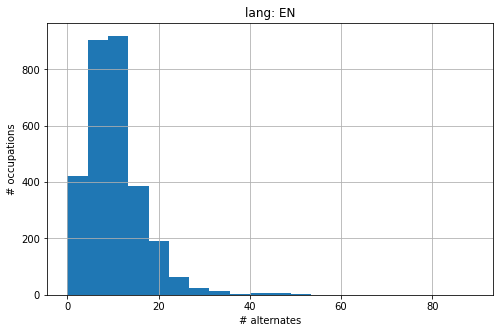

In [40]:
import pandas.io.sql as psql
lang = 'en'
occupation_local = psql.read_sql(f"""
    SELECT * FROM
    (SELECT * FROM occupations WHERE data_set='esco') AS occ 
    LEFT JOIN (SELECT * FROM occupation_translations WHERE locale='{lang}') as occtr
    ON occ.id=occtr.occupation_id
    """, skill_conn)
import matplotlib.pyplot as plt
occupation_local.alternates.apply(lambda x: len(x) if isinstance(x,list) else 0).hist(bins=20,figsize=(8,5))
plt.xlabel('# alternates')
plt.ylabel('# occupations')
plt.title(f'lang: {lang.upper()}');

In [4]:
tags, pred_stats, user_stats = eu.get_stats(client)
pred_stats.to_csv('data/pred_stats.csv')
user_stats.to_csv('data/user_stats.csv')
tags.to_csv('data/tags.csv')

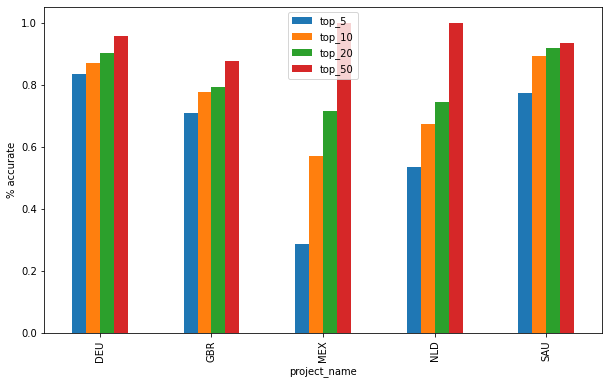

In [10]:
df = tags.groupby('project_name')[['top_5','top_10','top_20','top_50']].mean()
df.plot.bar(figsize=( 10,6))
plt.ylabel('% accurate');

In [54]:
tags, pred_stats, user_stats = eu.get_stats(client)

In [42]:
'/'.join(occupation_local.alternates.sample().iloc[0])

'communication analyst/communication studies scholar/communication studies research scientist/communication research scientist/communication studies research analyst/communication scholar/communication studies researcher/communication science researcher/communications scientist/communication studies analyst/communication research analyst/communication researcher'